# Negative L1 norm prior experiment

This code attempts to learn the 16D prior
$J(x) = -||x||_1$
assuming we have access to training data $\{y_i, S(y_i)\}$, $S(y_i) = -t/2 - |x|$

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/NegL1_prior_16D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,t=1.0):
    # Negative L1 Norm J(x) = -||x||_1
    # S(x, t) = -t/2 - |x| (per dimension)
    # For n dimensions: S(x, t) = - (n*t)/2 - ||x||_1
    
    dim = y.shape[1]
    l1_norm = np.sum(np.abs(y), axis=1)
    return -(t) / 2.0 - l1_norm


def prior_true(y):
    # J(x) = -||x||_1
    return -np.sum(np.abs(y), axis=1)


def cvx_true(y,t=1.0):
    '''
    Computes Psi(y) = 0.5*||y||^2 - S(y,t).
    The target convex function to learn.
    '''
    return 0.5 * euclid_norm_sq(y) - hjsol_true(y, t)


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,t=1.0) 
    x2_0_cvx_true = cvx_true(x2_0_points,t=1.0)

    x1_0_prior_true = prior_true(x1_0_points)
    x2_0_prior_true = prior_true(x2_0_points)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_cvx_est, "-", label="LPN")
    plt.plot(xi, x1_0_cvx_true, "--", label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the convex function, Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Convex functions(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_cvx_est, "-", label="LPN")
        plt.plot(xi, x2_0_cvx_true, "--", label="Ref")
        plt.grid(True)
        plt.title(f"Cross sections ($0,x_2$,0) of the convex function, Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Convex functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_prior_est, "-",label="LPN")
    plt.plot(xi, x1_0_prior_true, "-",label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the prior function,Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('Prior functions ($x_1$,0)')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_prior_est, "-", label="LPN")
        plt.plot(xi, x2_0_prior_true, "-", label="Ref")
        plt.grid("on")
        plt.title(f"Cross sections ($0,x_2$,0) of the prior function,Dim {dim}")
        plt.xlabel('$x_1$')
        plt.ylabel('Prior functions ($0,x_2$,0)')
        plt.legend()
    plt.tight_layout()

def plot_all(model,a,spacing,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 16

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 20000
Iterations = 500000

# LPN model parameters
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,t=1.0).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-3
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 5937.66162109375
iteration 0 loss 1665.9122314453125


iteration 5000 loss 0.854217529296875


iteration 10000 loss 0.28635138273239136


iteration 15000 loss 0.08768853545188904


iteration 20000 loss 0.05614301189780235


iteration 25000 loss 0.047169528901576996


iteration 30000 loss 0.03664398193359375


iteration 35000 loss 1.6752945184707642


iteration 40000 loss 0.028211016207933426


iteration 45000 loss 0.024763237684965134


iteration 50000 loss 0.022586900740861893


iteration 55000 loss 0.20350821316242218


iteration 60000 loss 0.019844673573970795


iteration 65000 loss 0.18378634750843048


iteration 70000 loss 0.01735023222863674


iteration 75000 loss 0.017281556501984596


iteration 80000 loss 0.01565205119550228


iteration 85000 loss 0.025010570883750916


iteration 90000 loss 0.014050914905965328


iteration 95000 loss 0.013355406932532787


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.01671164482831955


iteration 105000 loss 0.011481711640954018


iteration 110000 loss 0.010365035384893417


iteration 115000 loss 0.009600521996617317


iteration 120000 loss 0.008951104246079922


iteration 125000 loss 0.00840489286929369


iteration 130000 loss 0.007924173958599567


iteration 135000 loss 0.007496297359466553


iteration 140000 loss 0.007123952265828848


iteration 145000 loss 0.006775465328246355


iteration 150000 loss 0.00646132742986083


iteration 155000 loss 0.006172762252390385


iteration 160000 loss 0.005903236102312803


iteration 165000 loss 0.005654480773955584


iteration 170000 loss 0.005427161231637001


iteration 175000 loss 0.005212967749685049


iteration 180000 loss 0.00502089923247695


iteration 185000 loss 0.004830061458051205


iteration 190000 loss 0.0046506342478096485


iteration 195000 loss 0.004490898922085762


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.004340026993304491


iteration 205000 loss 0.004281038884073496


iteration 210000 loss 0.004137377254664898


iteration 215000 loss 0.0040136054158210754


iteration 220000 loss 0.0038954231422394514


iteration 225000 loss 0.00378177291713655


iteration 230000 loss 0.0036707136314362288


iteration 235000 loss 0.003562500001862645


iteration 240000 loss 0.003465837799012661


iteration 245000 loss 0.0033741805236786604


iteration 250000 loss 0.00328528368845582


iteration 255000 loss 0.0031977826729416847


iteration 260000 loss 0.0031095463782548904


iteration 265000 loss 0.00303096417337656


iteration 270000 loss 0.0029569517355412245


iteration 275000 loss 0.00288564944639802


iteration 280000 loss 0.002815432380884886


iteration 285000 loss 0.0027470802888274193


iteration 290000 loss 0.002679583616554737


iteration 295000 loss 0.0026117435190826654


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.002551304642111063


iteration 305000 loss 0.002534623956307769


iteration 310000 loss 0.002466412028297782


iteration 315000 loss 0.002401007805019617


iteration 320000 loss 0.0023378171026706696


iteration 325000 loss 0.00227696867659688


iteration 330000 loss 0.002218333538621664


iteration 335000 loss 0.0021623342763632536


iteration 340000 loss 0.002106615575030446


iteration 345000 loss 0.0020561516284942627


iteration 350000 loss 0.0020055470522493124


iteration 355000 loss 0.0019568700809031725


iteration 360000 loss 0.0019115663599222898


iteration 365000 loss 0.0018665851093828678


iteration 370000 loss 0.0018223138758912683


iteration 375000 loss 0.0017825529212132096


iteration 380000 loss 0.0017431218875572085


iteration 385000 loss 0.0017042441759258509


iteration 390000 loss 0.0016683493740856647


iteration 395000 loss 0.0016330791404470801


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.0015981117030605674


iteration 405000 loss 0.0015893778763711452


iteration 410000 loss 0.0015617228345945477


iteration 415000 loss 0.001533765229396522


iteration 420000 loss 0.0015065858606249094


iteration 425000 loss 0.0014801162760704756


iteration 430000 loss 0.00145419267937541


iteration 435000 loss 0.0014288779348134995


iteration 440000 loss 0.0014041261747479439


iteration 445000 loss 0.001379842753522098


iteration 450000 loss 0.0013560861116275191


iteration 455000 loss 0.001332852290943265


iteration 460000 loss 0.0013101533986628056


iteration 465000 loss 0.00128787977155298


iteration 470000 loss 0.0012660399079322815


iteration 475000 loss 0.001244671642780304


iteration 480000 loss 0.001223697792738676


iteration 485000 loss 0.0012031241785734892


iteration 490000 loss 0.0011829717550426722


iteration 495000 loss 0.0011632181704044342


L2 loss -- Plot

loss 328.4713134765625


loss 250.7175750732422


loss 220.91854858398438


loss 208.5855712890625


loss 203.1095733642578


loss 200.63037109375


loss 199.56838989257812


loss 199.164794921875


loss 199.03717041015625


loss 199.0059814453125


loss 199.00062561035156


loss 199.00003051757812


loss 199.0


loss 199.0


loss 199.0


loss 199.0


loss 199.0


loss 199.0


loss 199.0


loss 199.0


loss 199.0


loss 199.0


loss 199.0


loss 199.0


loss 199.0


loss 199.0


loss 199.0


loss 199.0


loss 199.0


loss 199.0


loss 199.0


loss 199.0


loss 199.0


loss 199.0


loss 199.0


loss 199.0


loss 199.0


loss 199.0


loss 199.0


loss 199.0


final mse:  8.223692837816543e-09
max, min: 2.3022432 -2.1722856
loss 328.4713134765625


loss 258.423095703125


loss 234.5428466796875


loss 224.38026428222656


loss 219.88003540039062


loss 217.9671630859375


loss 217.22821044921875


loss 216.98291015625


loss 216.91748046875


loss 216.90457153320312


loss 216.90289306640625


loss 216.9027557373047


loss 216.9027557373047


loss 216.9027557373047


loss 216.9027557373047


loss 216.90277099609375


loss 216.9027557373047


loss 216.9027557373047


loss 216.9027557373047


loss 216.90277099609375


loss 216.90277099609375


loss 216.9027557373047


loss 216.9027557373047


loss 216.9027557373047


loss 216.90274047851562


loss 216.90277099609375


loss 216.9027557373047


loss 216.9027557373047


loss 216.9027557373047


loss 216.9027557373047


loss 216.9027557373047


loss 216.9027557373047


loss 216.9027557373047


loss 216.9027557373047


loss 216.9027557373047


loss 216.90274047851562


loss 216.9027557373047


loss 216.9027557373047


loss 216.9027557373047


loss 216.9027557373047


final mse:  9.728255534469099e-09
max, min: 2.0907254 -2.0846336


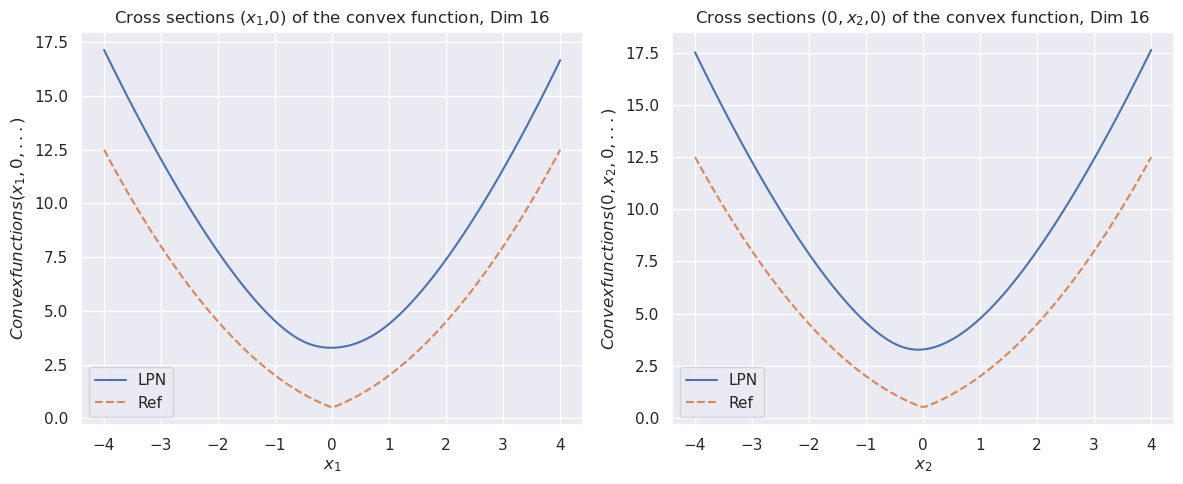

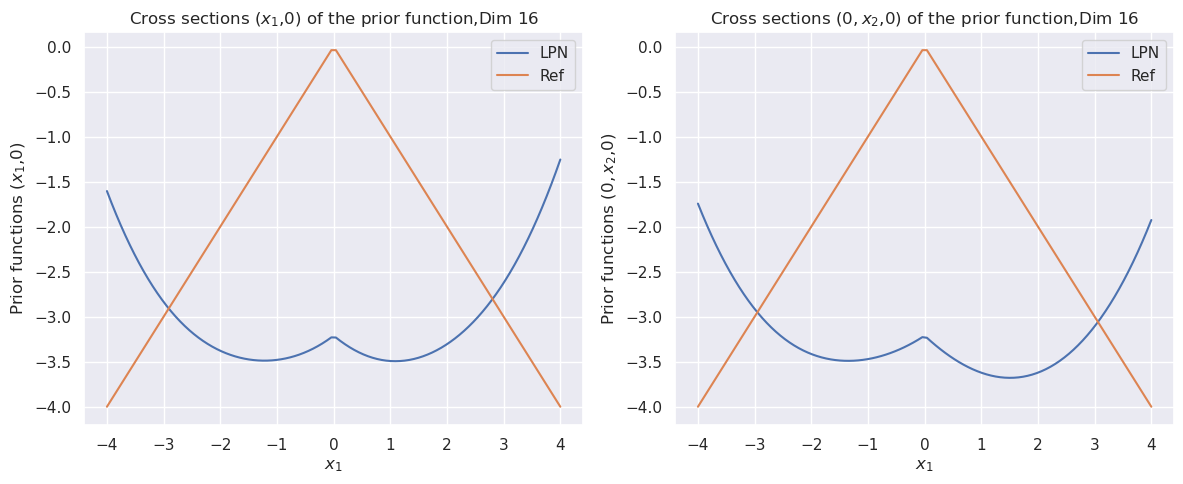

In [7]:
plot_all(lpn_model,a,spacing,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device)

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)

# --- Train 2nd LPN ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-3 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 1735.32080078125
iteration 0 loss 212.46292114257812


iteration 5000 loss 0.5375559329986572


iteration 10000 loss 0.37461596727371216


iteration 15000 loss 0.298385888338089


iteration 20000 loss 0.27492067217826843


iteration 25000 loss 0.23691408336162567


iteration 30000 loss 0.21916326880455017


iteration 35000 loss 0.20203933119773865


iteration 40000 loss 0.17805646359920502


iteration 45000 loss 0.16053438186645508


iteration 50000 loss 0.17797237634658813


iteration 55000 loss 0.14095991849899292


iteration 60000 loss 0.1255594938993454


iteration 65000 loss 0.1441226452589035


iteration 70000 loss 0.17106957733631134


iteration 75000 loss 0.11062149703502655


iteration 80000 loss 0.1047031432390213


iteration 85000 loss 0.09319110959768295


iteration 90000 loss 0.08306463062763214


iteration 95000 loss 0.0850893184542656


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.07768375426530838


iteration 105000 loss 0.0717705637216568


iteration 110000 loss 0.06448812037706375


iteration 115000 loss 0.059944480657577515


iteration 120000 loss 0.05579136684536934


iteration 125000 loss 0.05191788077354431


iteration 130000 loss 0.04914548248052597


iteration 135000 loss 0.04654427990317345


iteration 140000 loss 0.044033389538526535


iteration 145000 loss 0.04189008101820946


iteration 150000 loss 0.04002532735466957


iteration 155000 loss 0.038130853325128555


iteration 160000 loss 0.03641531988978386


iteration 165000 loss 0.03504897281527519


iteration 170000 loss 0.0337715819478035


iteration 175000 loss 0.03258441761136055


iteration 180000 loss 0.03121238388121128


iteration 185000 loss 0.03010871820151806


iteration 190000 loss 0.02912701666355133


iteration 195000 loss 0.0282482597976923


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.027377065271139145


iteration 205000 loss 0.026833122596144676


iteration 210000 loss 0.025820868089795113


iteration 215000 loss 0.02507716976106167


iteration 220000 loss 0.024331489577889442


iteration 225000 loss 0.023586256429553032


iteration 230000 loss 0.022833965718746185


iteration 235000 loss 0.022144222632050514


iteration 240000 loss 0.02157372608780861


iteration 245000 loss 0.021016515791416168


iteration 250000 loss 0.02044891193509102


iteration 255000 loss 0.019812632352113724


iteration 260000 loss 0.019349513575434685


iteration 265000 loss 0.018901290372014046


iteration 270000 loss 0.01846246048808098


iteration 275000 loss 0.018019426614046097


iteration 280000 loss 0.017574230208992958


iteration 285000 loss 0.01721452921628952


iteration 290000 loss 0.016865842044353485


iteration 295000 loss 0.016453010961413383


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.016071077436208725


iteration 305000 loss 0.016025103628635406


iteration 310000 loss 0.015712546184659004


iteration 315000 loss 0.015274117700755596


iteration 320000 loss 0.014862005598843098


iteration 325000 loss 0.01447357889264822


iteration 330000 loss 0.014102648943662643


iteration 335000 loss 0.013749001547694206


iteration 340000 loss 0.013410302810370922


iteration 345000 loss 0.013089730404317379


iteration 350000 loss 0.012781093828380108


iteration 355000 loss 0.012483816593885422


iteration 360000 loss 0.012198682874441147


iteration 365000 loss 0.01192476972937584


iteration 370000 loss 0.011661207303404808


iteration 375000 loss 0.011406530626118183


iteration 380000 loss 0.011160104535520077


iteration 385000 loss 0.010921508073806763


iteration 390000 loss 0.010691970586776733


iteration 395000 loss 0.010472367517650127


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.010259666480123997


iteration 405000 loss 0.010225474834442139


iteration 410000 loss 0.01018490456044674


iteration 415000 loss 0.010145995765924454


iteration 420000 loss 0.010108144953846931


iteration 425000 loss 0.010071036405861378


iteration 430000 loss 0.010034510865807533


iteration 435000 loss 0.009998469613492489


iteration 440000 loss 0.009962858632206917


iteration 445000 loss 0.009927649050951004


iteration 450000 loss 0.009892791509628296


iteration 455000 loss 0.009858297184109688


iteration 460000 loss 0.009824111126363277


iteration 465000 loss 0.009790184907615185


iteration 470000 loss 0.009756557643413544


iteration 475000 loss 0.00972316786646843


iteration 480000 loss 0.00969004537910223


iteration 485000 loss 0.009657161310315132


iteration 490000 loss 0.0096245426684618


iteration 495000 loss 0.009592138230800629


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


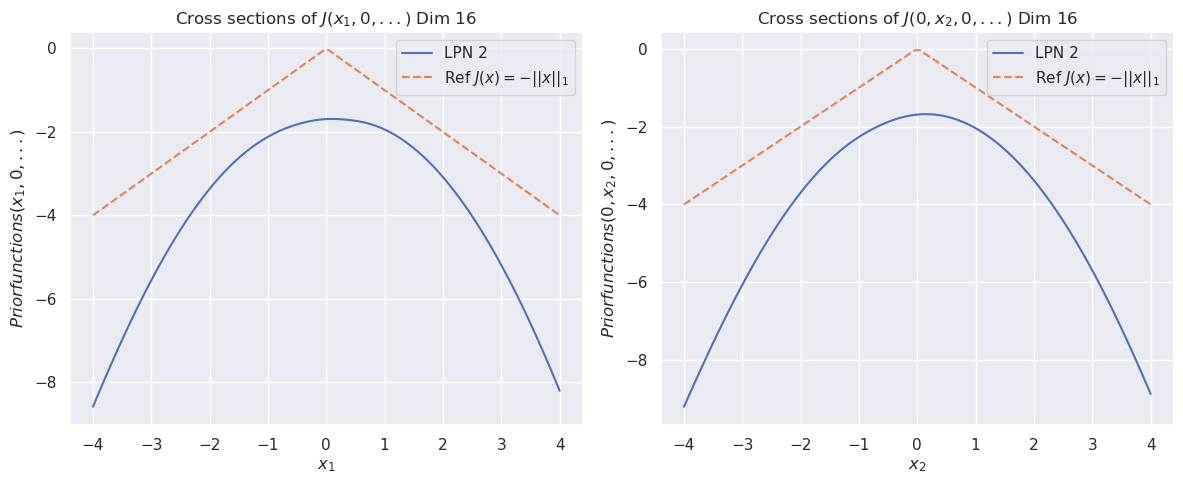

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=-||x||_1$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Prior functions (x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=-||x||_1$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Prior functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim)